Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_14[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

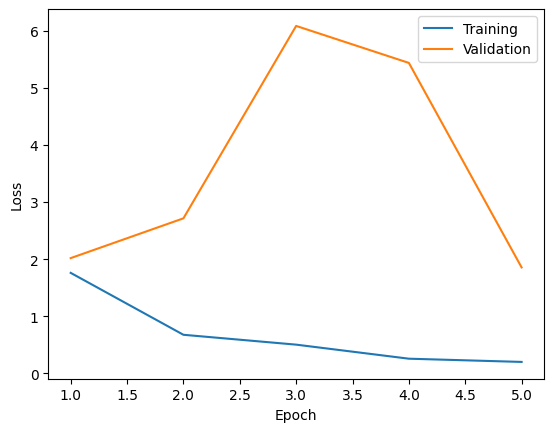

c:\Users\jeanp\OneDrive\Desktop\Thesis Environment\ipcv-env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as models/horses2.h5
1/1 [==============================] - 3s 3s/step


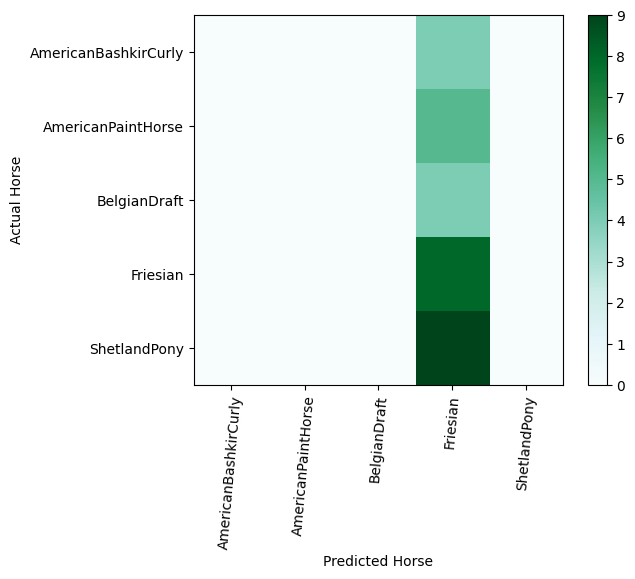

1/1 [==============================] - 0s 148ms/step
Prediction for ABC1.jpg: [[1.0000000e+00 3.5829111e-13 1.3910139e-14 5.2661413e-13 8.2570228e-17]] Class: AmericanBashkirCurly
Prediction for ABC2.jpg: [[9.9632108e-01 3.9773670e-04 1.5973373e-03 1.6348561e-03 4.8896120e-05]] Class: AmericanBashkirCurly
Prediction for ABC3.jpg: [[0.04315003 0.03890092 0.16829549 0.00108178 0.74857175]] Class: ShetlandPony
Prediction for ABC4.jpg: [[9.9988723e-01 3.0820824e-09 7.3187321e-06 2.8047102e-06 1.0262975e-04]] Class: AmericanBashkirCurly
Prediction for AP1.jpg: [[8.63785374e-07 9.99982119e-01 5.84203190e-06 4.50750804e-07
  1.06902635e-05]] Class: AmericanPaintHorse
Prediction for AP2.jpg: [[2.6808243e-07 9.9956149e-01 4.0870052e-04 2.2748372e-05 6.8140725e-06]] Class: AmericanPaintHorse
Prediction for AP3.jpg: [[7.3127355e-13 1.0000000e+00 5.5282570e-09 1.7781368e-10 7.7787706e-13]] Class: AmericanPaintHorse
Prediction for AP4.jpg: [[4.8490750e-07 9.9999702e-01 1.1608151e-07 2.2517552e-06 7

In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

# Load the ResNet-50 model
base_model = keras.applications.resnet.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Print the summary of the base model
print(base_model.summary())

# Set your data folder and parameters
data_folder = 'data - Copy/horse_photos'
pretrained_size = (224, 224)
batch_size = 30

datagen = image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

classnames = list(train_generator.class_indices.keys())
print("Class names:", classnames)

for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
prediction_layer = keras.layers.Dense(len(classnames), activation='softmax')(x)
model = keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

learning_rate = 0.0001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Print the summary of the entire model
print(model.summary())

# Train the model
num_epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=num_epochs
)

# Plot training and validation loss
epoch_nums = range(1, num_epochs + 1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Save the trained model
modelFileName = 'models/horses2.h5'
model.save(modelFileName)
del model
print('Model saved as', modelFileName)

# Load the saved model for inference
model = keras.models.load_model('models/horses2.h5')

# Generate predictions from validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]
class_probabilities = model.predict(x_test)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.BuGn)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Horse")
plt.ylabel("Actual Horse")
plt.show()

# Inference on new images
image_folder = './inferencing'
image_files = os.listdir(image_folder)

img_width, img_height = 224, 224

preprocessed_images = []
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    preprocessed_images.append(img_preprocessed)

predictions = [model.predict(img) for img in preprocessed_images]

# Display predictions
for i, img_file in enumerate(image_files):
    index = int(np.argmax(predictions[i], axis=1)[0])
    print(f"Prediction for {img_file}: {predictions[i]} Class: {classnames[index]}")